# Оглавление

- [Вступление](#intro)
- [Файлы с данными](#data)
- [Предобработка и исследовательский анализ](#preprocessing)
  - [Пропуски](#missing)
  - [Дубликаты](#dublicated)
    - [Явные дубликаты](#ob_dublicated)
    - [Неявные дубликаты](#imp_dublicated)
  - [Изменение типов данных](#types)
  - [Аномалии](#anomalies)
  - [Промежуточный вывод по предобработке](#prep_conclusion)
  - [Исследовательский анализ](#eda)
  - [Выводы по исследовательскому анализу](#eda_conclusion)
- [Формулировка ML-задачи](#ml_task)
  - [Расчёт прибыли без учёта депозитов](#profit_no_deposits)
  - [Вывод по расчёту прибыли без депозитов](#no_deposits_conclusion)
- [Разработка ML модели](#ml_model)
  - [Подготовка данных для модели](#data_preparation)
  - [Случайный лес](#rf)
  - [Древо решений](#dt)
  - [Тестовая выборка](#test)
  - [Вывод по ML моделе](#ml_conclusion)
- [Портрет "Ненадёжного" клиента](#unreliable_client)
- [Вывод](#conclusion)

<a id='intro'></a>
## Вступление

Сеть отелей добавила возможность бронирования без внесения предоплаты. При использовании такой системы есть риск убытков из-за отказов от брони. Перед нами стоит задача разработать систему предсказывающую отказ от бронирования. Если модель предскажет отказ, то данному клиенту будет предложено внести депозит в размере 80% от стоимости.

Нам предоставлены два файла с данными, один из которых содержит данные необходимые для обучения модели, другой для её тестирования. Изучим эти данные, сделаем предобработку при необходимости. До создания модели, проведём исследовательский анализ данных и сделаем выводы по нему. После этого займёмся созданием модели.

### Предоставленые дополнительные данные

Существует несколько типов номеров в данной сети отелей и в зависимсти от этого назначается стоимость за одну ночь. Присутствуют также затраты на уборку, если клиент снимает номер надолго, то убираются каждые два дня.

- категория A: за ночь — 1 000, разовое обслуживание — 400;
- категория B: за ночь — 800, разовое обслуживание — 350;
- категория C: за ночь — 600, разовое обслуживание — 350;
- категория D: за ночь — 550, разовое обслуживание — 150;
- категория E: за ночь — 500, разовое обслуживание — 150;
- категория F: за ночь — 450, разовое обслуживание — 150;
- категория G: за ночь — 350, разовое обслуживание — 150.

Сеть отелей использует сезонные коэффициенты:

- Весна, Осень: цены повышаются на 20%
- Лето: цены повышаются на 40%

За убытки в случае отмены брони считается стоимость одной уборки и одной ночи с учётом сезона.

На разработку системы выделен бюджет 400 тысяч. Внедрение должно окупится за тестовый период.

<a id='data'></a>
## Файлы с данными

**Импортируем необходимые библиотеки**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder 

from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

**Читаем исходные файлы**

In [2]:
try:
    hotels_train = pd.read_csv('hotel_train.csv')
    hotels_test = pd.read_csv('hotel_test.csv')
except:
    hotels_train = pd.read_csv('/datasets/hotel_train.csv')
    hotels_test = pd.read_csv('/datasets/hotel_test.csv')

**Основная информация о датафреймах**

In [3]:
hotels_train.info()
hotels_test.info()

In [4]:
pd.set_option('display.max_columns', 50)
display(hotels_train.head(10))
display(hotels_test.head(10))

- В обоих датасетах 25 колонок. В тренировочных данных 65229 строк, в тестовых - 32412.
- Колонки `lead_time`, `adults`, `children`, `babies` должны быть в целочисленном формате, а тут мы видим вещественный тип. На этапе предобработки посмотрим более детально на эти столбцы.

Посмотрели на основную базовую информацию содержащуюся в датасетах, теперь приступим к предобработке и исследовательскому анализу.

<a id='preprocessing'></a>
## Предобработка и исследовательский анализ данных

<a id='missing'></a>
### Пропуски

Для начала посмотрим есть ли пропуски в данных.

In [5]:
hotels_train.isna().sum()

In [6]:
hotels_test.isna().sum()

Пропусков нет. Проверим явные дубликаты.

<a id='dublicated'></a>
### Дубликаты

<a id='ob_dublicated'></a>
#### Явные дубликаты

In [7]:
hotels_train.duplicated().sum()

In [8]:
hotels_test.duplicated().sum()

Явных дубликатов нет.

<a id='imp_dublicated'></a>
#### Неявные дубликаты

 Проверим те столбцы в которых потенциально могут находится неявные дубликаты: `arrival_date_month`, `meal`, `country`, `distribution_channel`, `reserved_room_type`, `customer_type`

In [9]:
display(hotels_train['arrival_date_month'].unique())
display(hotels_test['arrival_date_month'].unique())

Колонка `arrival_date_month` содержит корректные значения.

In [10]:
display(hotels_train['meal'].unique())
display(hotels_test['meal'].unique())

В столбце `meal` есть неявные дубликаты, а так же нарушен стиль заполнения (есть лишние пробелы). Уберём пробелы.

In [11]:
hotels_train['meal'] = hotels_train['meal'].str.strip()
hotels_test['meal'] = hotels_test['meal'].str.strip()

In [12]:
display(hotels_train['meal'].unique())
display(hotels_test['meal'].unique())

После корректировки стиля заполнения, неявные дубликаты пропали. Можем приступать к следующему столбцу.

In [13]:
display(hotels_train['country'].unique())
display(hotels_test['country'].unique())

`country` содержит корректные значения.

In [14]:
display(hotels_train['distribution_channel'].unique())
display(hotels_test['distribution_channel'].unique())

`distribution_channel` содержит корректные значения.

In [15]:
display(hotels_train['reserved_room_type'].unique())
display(hotels_test['reserved_room_type'].unique())

В стоблце `reserved_room_type` значения корректные, но содержат лишнии пробелы. Уберём их.

In [16]:
hotels_train['reserved_room_type'] = hotels_train['reserved_room_type'].str.strip()
hotels_test['reserved_room_type'] = hotels_test['reserved_room_type'].str.strip()

In [17]:
display(hotels_train['reserved_room_type'].unique())
display(hotels_test['reserved_room_type'].unique())

Пробелы убрали, приступаем к следующей колонке.

In [18]:
display(hotels_train['customer_type'].unique())
display(hotels_test['customer_type'].unique())

`customer_type` содержит корректные значения

<a id='types'></a>
### Изменения типов данных

Ранее заметили что колонки `lead_time`, `adults`, `children`, `babies` находятся в вещественном типе, а должны в целочисленном. Произведём изменения типа в этих колонках.

In [19]:
hotels_train['lead_time'] = hotels_train['lead_time'].astype('int16')
hotels_train['adults'] = hotels_train['adults'].astype('int8')
hotels_train['children'] = hotels_train['children'].astype('int8')
hotels_train['babies'] = hotels_train['babies'].astype('int8')

hotels_test['lead_time'] = hotels_test['lead_time'].astype('int16')
hotels_test['adults'] = hotels_test['adults'].astype('int8')
hotels_test['children'] = hotels_test['children'].astype('int8')
hotels_test['babies'] = hotels_test['babies'].astype('int8')

А так же скорректируем остальные целочисленные колонки. Они указаны в типе int64 что хранящейся в них информации избыточно, поменяем на int16 и int8.

In [20]:
hotels_train['is_canceled'] = hotels_train['is_canceled'].astype('int8')
hotels_train['arrival_date_year'] = hotels_train['arrival_date_year'].astype('int16')
hotels_train['arrival_date_week_number'] = hotels_train['arrival_date_week_number'].astype('int8')
hotels_train['arrival_date_day_of_month'] = hotels_train['arrival_date_day_of_month'].astype('int8')
hotels_train['stays_in_weekend_nights'] = hotels_train['stays_in_weekend_nights'].astype('int8')
hotels_train['stays_in_week_nights'] = hotels_train['stays_in_week_nights'].astype('int8')
hotels_train['is_repeated_guest'] = hotels_train['is_repeated_guest'].astype('int8')
hotels_train['previous_cancellations'] = hotels_train['previous_cancellations'].astype('int8')
hotels_train['previous_bookings_not_canceled'] = hotels_train['previous_bookings_not_canceled'].astype('int8')
hotels_train['booking_changes'] = hotels_train['booking_changes'].astype('int8')
hotels_train['days_in_waiting_list'] = hotels_train['days_in_waiting_list'].astype('int16')
hotels_train['required_car_parking_spaces'] = hotels_train['required_car_parking_spaces'].astype('int8')
hotels_train['total_of_special_requests'] = hotels_train['total_of_special_requests'].astype('int8')
hotels_train['total_nights'] = hotels_train['total_nights'].astype('int8')

hotels_test['is_canceled'] = hotels_test['is_canceled'].astype('int8')
hotels_test['arrival_date_year'] = hotels_test['arrival_date_year'].astype('int16')
hotels_test['arrival_date_week_number'] = hotels_test['arrival_date_week_number'].astype('int8')
hotels_test['arrival_date_day_of_month'] = hotels_test['arrival_date_day_of_month'].astype('int8')
hotels_test['stays_in_weekend_nights'] = hotels_test['stays_in_weekend_nights'].astype('int8')
hotels_test['stays_in_week_nights'] = hotels_test['stays_in_week_nights'].astype('int8')
hotels_test['is_repeated_guest'] = hotels_test['is_repeated_guest'].astype('int8')
hotels_test['previous_cancellations'] = hotels_test['previous_cancellations'].astype('int8')
hotels_test['previous_bookings_not_canceled'] = hotels_test['previous_bookings_not_canceled'].astype('int8')
hotels_test['booking_changes'] = hotels_test['booking_changes'].astype('int8')
hotels_test['days_in_waiting_list'] = hotels_test['days_in_waiting_list'].astype('int16')
hotels_test['required_car_parking_spaces'] = hotels_test['required_car_parking_spaces'].astype('int8')
hotels_test['total_of_special_requests'] = hotels_test['total_of_special_requests'].astype('int8')
hotels_test['total_nights'] = hotels_test['total_nights'].astype('int8')

In [21]:
hotels_train.info()
hotels_test.info()

Теперь все столбцы находятся в корректных типах.

<a id='anomalies'></a>
### Аномалии

Проверим есть ли в данных аномалии. Для начала выведем гистограммы по всем стобцам.

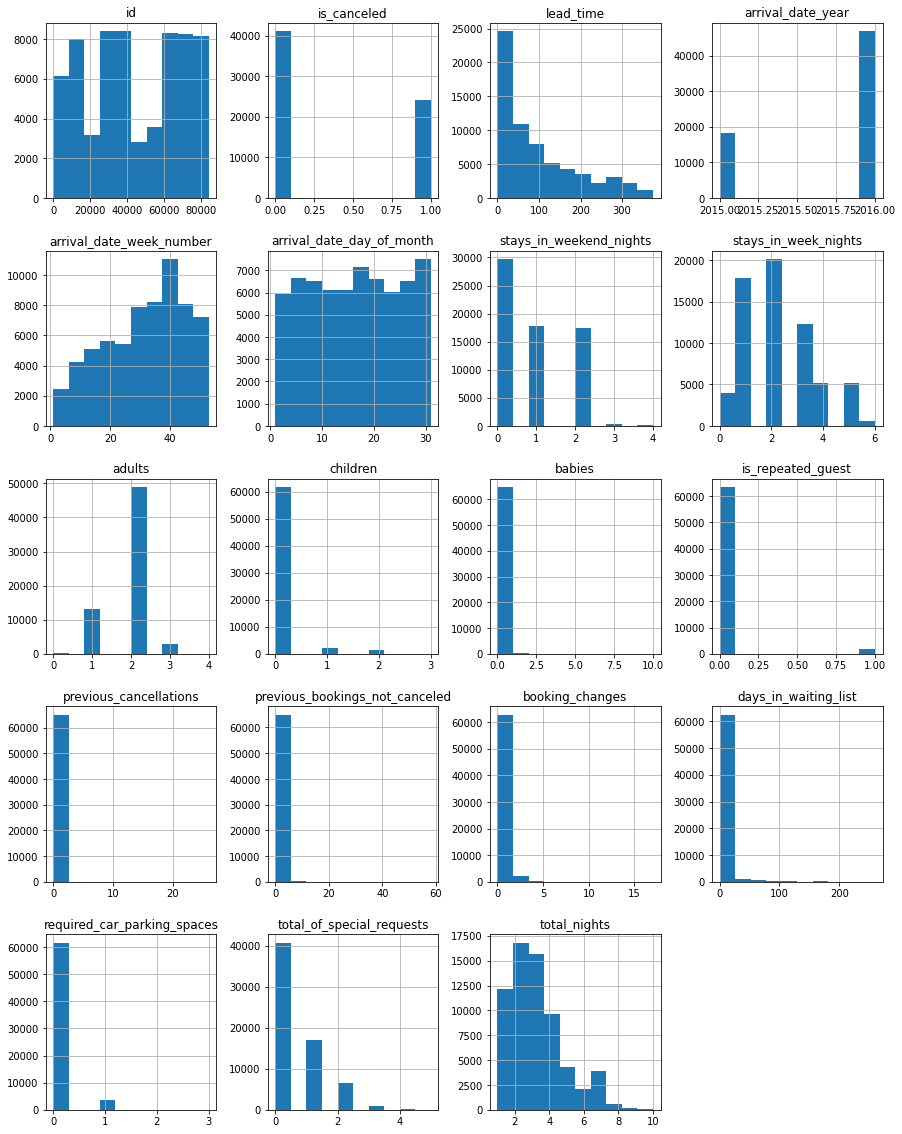

In [22]:
hotels_train.hist(figsize=(15, 20));

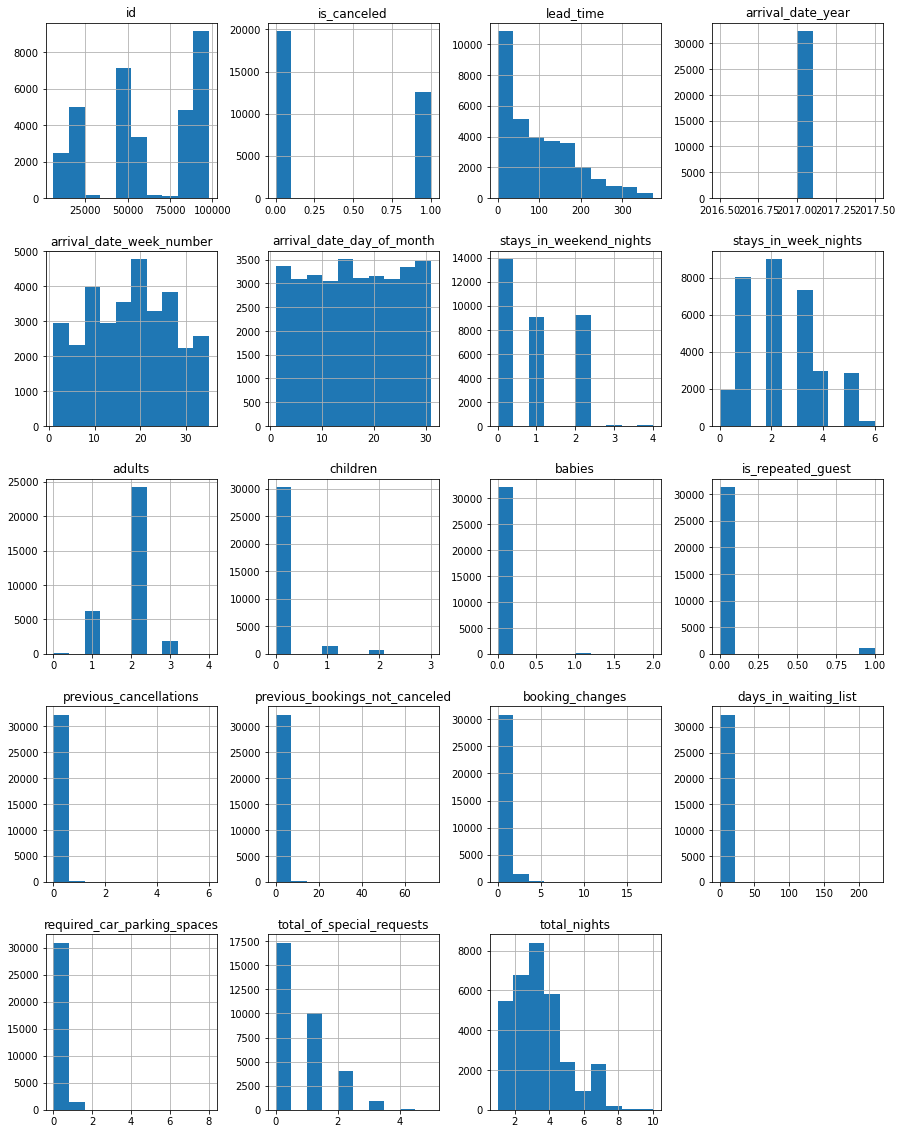

In [23]:
hotels_test.hist(figsize=(15, 20));

В тренировочных данных гистограмма колонки `babies` показывает что есть значения доходящие до 10, в то время как в тестовых только до 2. Посмотрим какие значения в ней находятся.

In [24]:
display(hotels_train['babies'].sort_values().unique())
display(hotels_test['babies'].sort_values().unique())

Видим что в обоих датасетах есть значения 0, 1, 2, но в тренировочном есть ещё 9, 10. Данные значения скорей всего аномалии посмотрим сколько их.

In [25]:
hotels_train.query('babies > 2').sort_values(by='babies')

Нашли две строки, удалим их.

In [26]:
hotels_train = hotels_train.query('babies <= 2').reset_index(drop=True)

In [27]:
display(hotels_train['babies'].sort_values().unique())

Удалили аномалии в колонке `babies`.

В колонке `required_car_parking_spaces` наблюдаем потенциальные аномалии в тестовом датасете.

In [28]:
display(hotels_train['required_car_parking_spaces'].sort_values().unique())
display(hotels_test['required_car_parking_spaces'].sort_values().unique())

В обоих датасетах типичные значения 0, 1 , 2, 3. Но в тестовом есть ещё 8, посмотрим на их колличество.

In [29]:
hotels_test.query('required_car_parking_spaces > 3').sort_values(by='required_car_parking_spaces')

Нашли две строки, удалим их.

In [30]:
hotels_test = hotels_test.query('required_car_parking_spaces <= 3').reset_index(drop=True)

In [31]:
display(hotels_test['required_car_parking_spaces'].sort_values().unique())

Удалили аномалии в колонке `required_car_parking_spaces`.

В колонке `adults` видим что есть значения 0, данные значения являются аномалиями, посмотрим сколько их.

In [32]:
display(hotels_train['adults'].sort_values().unique())
display(hotels_test['adults'].sort_values().unique())

In [33]:
hotels_train.query('adults < 1')

In [34]:
hotels_test.query('adults < 1')

Нашли 166 строк в тренировочном датасете и 69 в тестовом. Удалим их.

In [35]:
hotels_train = hotels_train.query('adults > 0').reset_index(drop=True)
hotels_test = hotels_test.query('adults > 0').reset_index(drop=True)

<a id='prep_conclusion'></a>
### Промежуточный вывод по предобработке данных

Проверили имеющиеся в наличии датасеты на пропуски, дубликаты, аномалии, а так же проверили корректность типов данных в столбцах.

- Пропуски в данных отсутствовали.
- Дубликаты проверяли явные и неявные.
 - Явных дубликатов не было.
 - Нашли неявные в колонке `meal`, а так же в процессе проверки выявили некоректный стиль заполнения в данной колонке и `reserved_room_type`. После исправления стиля неявных дубликатов в данных не осталось.
- Выявили аномалии в трёх колонках `babies`, `required_car_parking_spaces` и `adults`. В сумме 239 аномальные строки, 168 из тренировочного датасета и 71 из тестового. Эти строки удалили.
- Столбцы `lead_time`, `adults`, `children`, `babies` находились в вещественном типе. Исправили на целочисленный.

С предобработкой закончили. Приступим к исследовательскому анализу данных.

<a id='eda'></a>
### Исследовательский анализ данных

**Отмена заказа**

Посмотрим на отношение отменённых и не отменённых заказов.

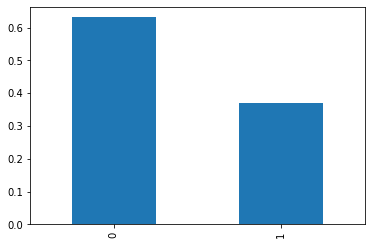

In [36]:
class_frequency = hotels_train['is_canceled'].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar');

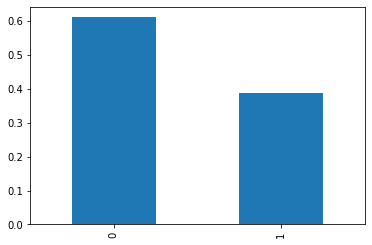

In [37]:
class_frequency = hotels_test['is_canceled'].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar');

Есть небольшой дисбаланс классов, но не критичный. 63% и 61% - не отменённых заказы в тренировочных и тестовых данных соответсвенно. 37%, 39% - отменённые.

**Время между бронированием и прибытием**

Построим гистограммы и посмотрим как распределены значения в колонке `lead_time`.

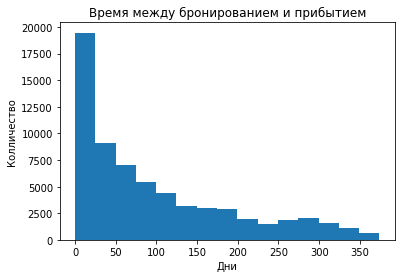

In [38]:
fig, ax = plt.subplots()
ax.hist(hotels_train['lead_time'], bins=15);
ax.set_title('Время между бронированием и прибытием')
ax.set_xlabel('Дни')
ax.set_ylabel('Колличество')
plt.show()

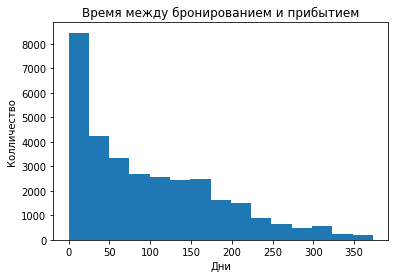

In [39]:
fig, ax = plt.subplots()
ax.hist(hotels_test['lead_time'], bins=15);
ax.set_title('Время между бронированием и прибытием')
ax.set_xlabel('Дни')
ax.set_ylabel('Колличество')
plt.show()

Видим что большая часть значений расположена ближе к 0 дней и имеется длинный хвост к году. Подобное распределение выглядит логично для данного столбца.

**Месяц заезда**

Посмотрим какие месяцы самые популярные, а какие менее.

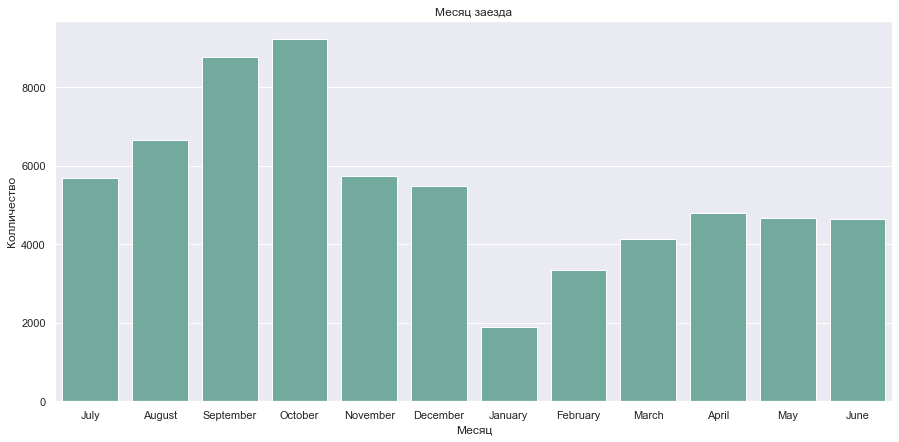

In [40]:
sns.set(style="darkgrid")

plt.figure(figsize=(15, 7))
sns.barplot(
    x='arrival_date_month', 
    y=hotels_train.index, 
    data=hotels_train, 
    estimator=len, 
    ci=None, 
    color='#69b3a2');
plt.title('Месяц заезда');
plt.xlabel('Месяц');
plt.ylabel('Колличество');

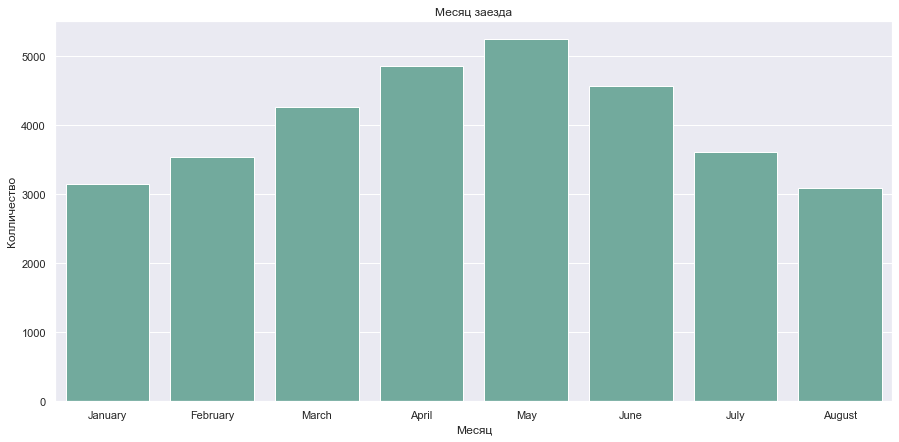

In [41]:
sns.set(style="darkgrid")

plt.figure(figsize=(15, 7))
sns.barplot(
    x='arrival_date_month', 
    y=hotels_test.index, 
    data=hotels_test, 
    estimator=len, 
    ci=None, 
    color='#69b3a2');
plt.title('Месяц заезда');
plt.xlabel('Месяц');
plt.ylabel('Колличество');

Первые два месяца осени оказались самыми популярными, а январь и февраль непопулярными. Данные выводы сделаны в первую очередь на тренировочных данных. В тестовых данных у нас имеются только данные по 8 первыми месяцам. Данные по осени в них отсутсвуют.

Посмотрим в каких меяцах чаще всего отменяют бронь.

In [42]:
hotels_train.pivot_table(index='arrival_date_month',
                         values='is_canceled',
                         aggfunc='mean') \
.sort_values(by='is_canceled', ascending=False)

In [43]:
hotels_test.pivot_table(index='arrival_date_month',
                         values='is_canceled',
                         aggfunc='mean') \
.sort_values(by='is_canceled', ascending=False)

Чаще всего отменяют бронь в июне и апреле. Меньше всего в начале года: январь, февраль, март.

**Повторные клиенты**

Посмотрим на колличество повторных клиентов и связь с отменой бронирования.

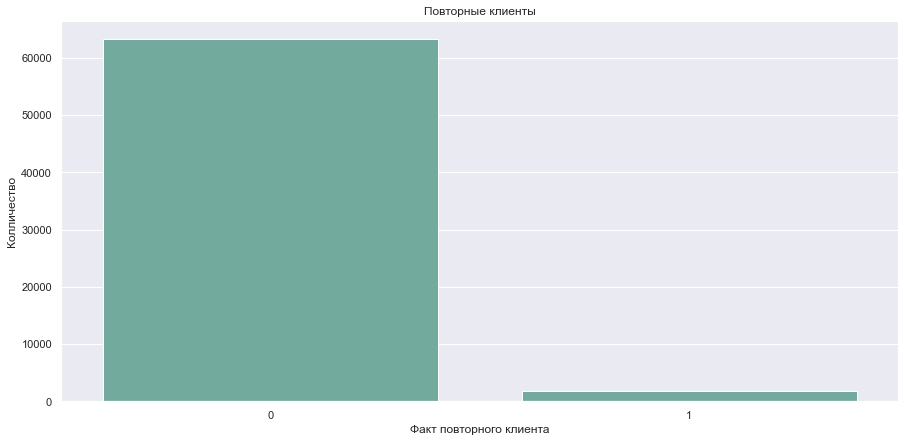

In [44]:
sns.set(style="darkgrid")

plt.figure(figsize=(15, 7))
sns.barplot(
    x='is_repeated_guest', 
    y=hotels_train.index, 
    data=hotels_train, 
    estimator=len, 
    ci=None, 
    color='#69b3a2');
plt.title('Повторные клиенты');
plt.xlabel('Факт повторного клиента');
plt.ylabel('Колличество');

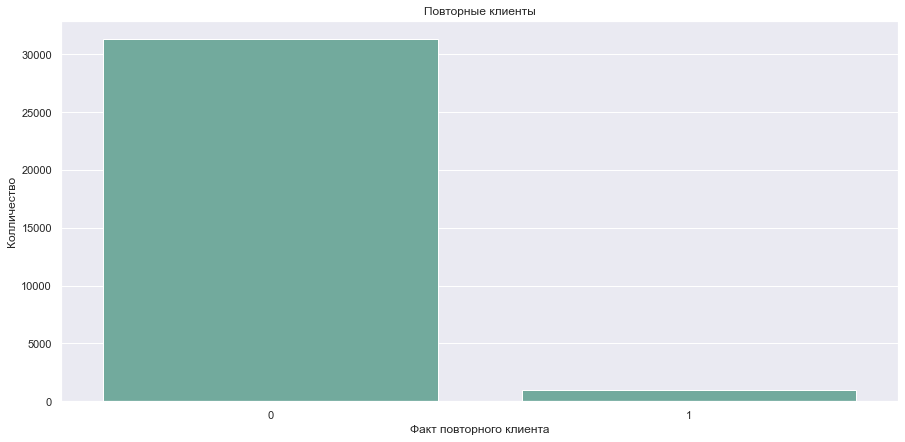

In [45]:
sns.set(style="darkgrid")

plt.figure(figsize=(15, 7))
sns.barplot(
    x='is_repeated_guest', 
    y=hotels_test.index, 
    data=hotels_test, 
    estimator=len, 
    ci=None, 
    color='#69b3a2');
plt.title('Повторные клиенты');
plt.xlabel('Факт повторного клиента');
plt.ylabel('Колличество');

In [46]:
hotels_train.pivot_table(index='is_repeated_guest',
                         values='is_canceled',
                         aggfunc='mean') \
.sort_values(by='is_canceled', ascending=False)

In [47]:
hotels_test.pivot_table(index='is_repeated_guest',
                         values='is_canceled',
                         aggfunc='mean') \
.sort_values(by='is_canceled', ascending=False)

Большинство клиентов бронируют в первый раз. Те клиенты которые делают бронь не первый раз менее склонны к её отмене.

**Общее колличество ночей**

Посмотрим есть ли связь общего колличества ночей и отменой брони.

In [48]:
hotels_train.pivot_table(index='total_nights',
                         values='is_canceled',
                         aggfunc='mean') \
.sort_values(by='is_canceled', ascending=False)

In [49]:
hotels_test.pivot_table(index='total_nights',
                         values='is_canceled',
                         aggfunc='mean') \
.sort_values(by='is_canceled', ascending=False)

Результаты в обоих датасетах различаются, но есть одна общая черта. Те кто снимают на одну ночь реже всего отменяют бронь.

In [50]:
train_plot = hotels_train.groupby('total_nights').agg(mean=('is_canceled', 'mean'))
test_plot = hotels_test.groupby('total_nights').agg(mean=('is_canceled', 'mean'))

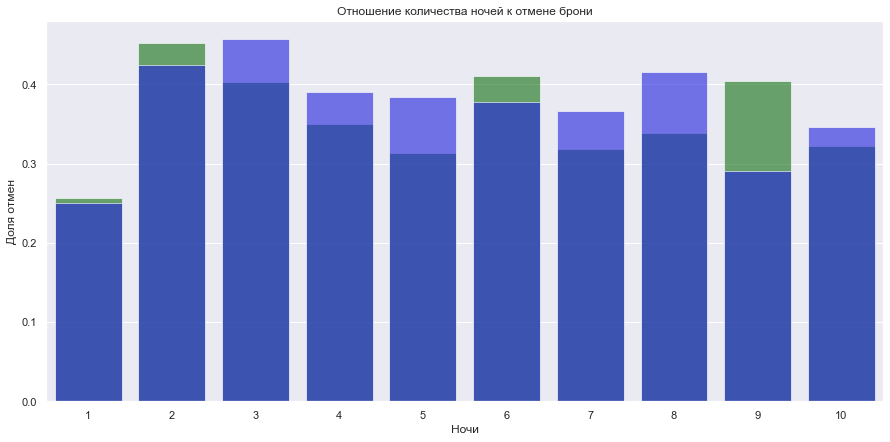

In [51]:
sns.set(style="darkgrid")
plt.figure(figsize=(15, 7))

sns.barplot(
    x=train_plot.index, 
    y='mean', 
    data=train_plot, 
    estimator=sum, 
    ci=None,
    alpha=0.6,
    color='green');


sns.barplot(
    x=test_plot.index, 
    y='mean', 
    data=test_plot, 
    estimator=sum, 
    ci=None,
    alpha=0.6,
    color='blue');

plt.title('Отношение количества ночей к отмене брони');
plt.xlabel('Ночи');
plt.ylabel('Доля отмен');

**Канал дистрибуции заказа**

Посмотрим как каналы дистрибуции влияют на отмену брони.

In [52]:
hotels_train.pivot_table(index='distribution_channel',
                         values='is_canceled',
                         aggfunc='mean') \
.sort_values(by='is_canceled', ascending=False)

In [53]:
hotels_test.pivot_table(index='distribution_channel',
                         values='is_canceled',
                         aggfunc='mean') \
.sort_values(by='is_canceled', ascending=False)

Результаты по обоим датасетам примерно одинаковые. TA/TO с отрывом самый ненадёжный канал. Direct и GDS самые надёжные. Corporate находится ближе к Direct и GDS.

**Тип заказчика**

Посмотрим влияет ли тип заказчки на отмену.

In [54]:
hotels_train.pivot_table(index='customer_type',
                         values='is_canceled',
                         aggfunc='mean') \
.sort_values(by='is_canceled', ascending=False)

In [55]:
hotels_test.pivot_table(index='customer_type',
                         values='is_canceled',
                         aggfunc='mean') \
.sort_values(by='is_canceled', ascending=False)

Можем сделать вывод что самыми надёжными являются групповые заезды. Остальные типы в датасетах сильно отличаются, по ним не можем однозначных выводов сделать.

**Специальные отметки**

Проверим влиет ли колличество специальных отметок на отмену.

In [56]:
hotels_train.pivot_table(index='total_of_special_requests',
                         values='is_canceled',
                         aggfunc='mean') \
.sort_values(by='is_canceled', ascending=False)

In [57]:
hotels_test.pivot_table(index='total_of_special_requests',
                         values='is_canceled',
                         aggfunc='mean') \
.sort_values(by='is_canceled', ascending=False)

Можем сделать вывод что клиенты которые не оставляют никаких специальных отметок более склонны к отмене брони чем те что оставляют хотя бы 1 отметку или более.

<a id='eda_conclusion'></a>
### Вывод по исследовательскому анализу данных

Посмотрели как различные данные могут влиять на отмену брони.

- Самыми ненадёжными месяцами оказались июнь и апрель, а начало года (январь, февраль, март) менее склонны к отмене.
- Клиенты которые делают бронь первый раз намного более склонны к отмене.
- Те кто снимают на одну ночь менее склонны к отмене.
- Выяснили что канал дистрибуции влияет на отмену. TA/TO самый ненадёжный в то время как Direct и GDS самые надёжные
- Тип заказчика так же влияет, групповые заезды самые надёжные. Но по остальным не можем сделать конкретных выводов.
- Наличии специальных отметок влияет на отмену. Клиенты которые не оставлют отметок более склонны к отмене.

Посмотрели на баланс классов. Есть небольшой дисбаланс в обоих датасетах, но не критичный.

<a id='ml_task'></a>
## Формулировка ML-задачи на основе бизнес-задачи

<a id='profit_no_deposits'></a>
### Расчёт прибыли без учёта депозитов

Расчитаем прибыль на тестовом датасете, без учёта депозитов предлагаемых системой предсказывающей отмену. Тоесть если клиент отменил бронь, то сеть теряет деньги потраченные на разовую уборку номера.

Расчёт прибыли будет вестись следующим образом:

**Цена номера (учитывая отменена ли бронь или нет) * Коэфициент * Колличество ночей - Затраты на уборку * Количество ночей (учитывая что если клиент снимает больше 2 ночей то уборка делается раз в два дня)**

Таким образом мы выясним прибыль с каждого клиента.

Для начала запишем константы которые нам понадобятся для рассчёта прибыли.

In [58]:
BUDGET = 400000 # Бюджет выделенный на разработку системы прогнозирования

A_PRICE = 1000 # Стоимости номеров различных категорий за ночь
B_PRICE = 800
C_PRICE = 600
D_PRICE = 550
E_PRICE = 500
F_PRICE = 450
G_PRICE = 350

A_MAINTENANCE = 400 # Затраты на разовую уборку номера, по категориям
B_MAINTENANCE = 350
C_MAINTENANCE = 350
D_MAINTENANCE = 150
E_MAINTENANCE = 150
F_MAINTENANCE = 150
G_MAINTENANCE = 150

SUMMER_COEF = 1.4 # Летний коэфициент
SPRING_FALL_COEF = 1.2 # Весенне-осенний коэфициент

DEPOSIT = 0.8 # Размер депозита

Для более удобной работы с коэфициентами создадим два списка с летними и осенне-весенними месяцами.

In [59]:
summer = ['June', 'July', 'August']
spring_fall = ['March', 'April', 'May', 'September', 'October', 'November']

Напишем функции с помощью которых добавим в датафрейм сезонные коэфициенты, цену за номер в соответсвии с её типом, стоимость разовой уборки в соответсвии с типом.

In [60]:
# Функция для добавления сезонного коэфициента
def coef(season):
    if season in summer:
        return SUMMER_COEF
    elif season in spring_fall:
        return SPRING_FALL_COEF
    else:
        return 1

# Функция для добавления стоймости за ночь    
def room_type(room_type):
    if room_type == 'A':
        return A_PRICE
    elif room_type == 'B':
        return B_PRICE
    elif room_type == 'C':
        return C_PRICE
    elif room_type == 'D':
        return D_PRICE
    elif room_type == 'E':
        return E_PRICE
    elif room_type == 'F':
        return F_PRICE
    elif room_type == 'G':
        return G_PRICE

# Функция для добавления стоймости уборки
def maintenance(room_type):
    if room_type == 'A':
        return A_MAINTENANCE
    elif room_type == 'B':
        return B_MAINTENANCE
    elif room_type == 'C':
        return C_MAINTENANCE
    elif room_type == 'D':
        return D_MAINTENANCE
    elif room_type == 'E':
        return E_MAINTENANCE
    elif room_type == 'F':
        return F_MAINTENANCE
    elif room_type == 'G':
        return G_MAINTENANCE

Теперь у нас есть необходимые функции, добавим данные столбцы в датафрейм.

In [61]:
hotels_test['coefficient'] = hotels_test['arrival_date_month'].apply(coef)
hotels_test['price_per_night'] = hotels_test['reserved_room_type'].apply(room_type)
hotels_test['maintenance_cost'] = hotels_test['reserved_room_type'].apply(maintenance)

In [62]:
hotels_test

Добавили и убедились что они добавлены корректно. Теперь нам нужно скорректировать стобец с ценой, с учётом тех клиентов которые отменили бронь.

In [63]:
hotels_test.loc[(hotels_test['is_canceled'] == 1), 'price_per_night'] = -hotels_test['price_per_night']

Изменили колонку с ценой за ночь для клиентов отменивших бронь. Теперь посчитаем итоговые расходы на уборку номера учтя количество ночей.

In [64]:
hotels_test.loc[(hotels_test['total_nights'] > 2) & (hotels_test['is_canceled'] != 1), 'maintenance_cost'] = \
hotels_test['maintenance_cost'] * ((hotels_test['total_nights'] + 1) // 2)

In [65]:
hotels_test

Сейчас в датафрейме у нас есть все данные необходимые для подсчёта прибыли с каждого клиента. Добавим столбец с данным рассчётом.

In [66]:
hotels_test.loc[(hotels_test['is_canceled'] == 1), 'income'] = \
    hotels_test['price_per_night'] * \
    hotels_test['coefficient'] - \
    hotels_test['maintenance_cost']

hotels_test.loc[(hotels_test['is_canceled'] == 0), 'income'] = \
    hotels_test['price_per_night'] * \
    hotels_test['coefficient'] * \
    hotels_test['total_nights'] - \
    hotels_test['maintenance_cost']

Посчитаем сколько сеть заработала за год.

In [68]:
income_without_deposit = hotels_test['income'].sum() * (12/8)
print(income_without_deposit)

<a id='no_deposits_conclusion'></a>
### Вывод по расчёту прибыли без депозитов

Получили 52.83 миллионов прибыли за год учитываю потери из-за бездепозитной системы. Сеть хочет ввести систему при которой используется модель машинного обучения предсказывающая отменит ли бронь клиент. Если модель предскажет что отменит, то будет предложен внести депозит в размере 80% от стоимости за ночь. На разработку этой системы выделено 400тысяч. Затраты должны окупится за тестовый период, тоесть с учётом модели мы должны получить прибыль за год на тестовом датасете не меньше чем 53.23миллионов. Приступим к следующему шагу - создание модели.

<a id='ml_model'></a>
## Разработка ML модели

<a id='data_preparation'></a>
### Подготовка данных для модели

**Удаление ненужных данных**

Удалим ненужные для обучения модели стобцы.

In [69]:
hotels_train = hotels_train.drop(['country',
                                  'id',
                                  'arrival_date_year'], axis=1).reset_index(drop=True)

hotels_test = hotels_test.drop(['country',
                                'id',
                                'arrival_date_year',
                                'coefficient',
                                'price_per_night',
                                'maintenance_cost',
                                'income'], axis=1).reset_index(drop=True)

In [70]:
display(hotels_train.shape)
display(hotels_test.shape)

Стобцы удалили, проверели размеры датасетов, в обоих одинаковое колличество стобцов. Можем приступить к кодировке категориальных переменных.

**Порядковое кодирование**

В качестве кодировки выберем порядковое кодирование (Ordinal Encoding). Прямое кодирование нам не подойдёт, так как у есть такие стобцы как например содержащие месяца и колличество вариантов в датафреймах отличается. В тестовом данные за осенние месяцы отсутсвуют. Если бы мы применяли прямое кодирование, то у нас было бы различное колличество столбцов.

In [71]:
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=1234)
encoder.fit(hotels_train)
train_ordinal = pd.DataFrame(encoder.transform(hotels_train),
                            columns=hotels_train.columns)

test_ordinal = pd.DataFrame(encoder.transform(hotels_test),
                            columns=hotels_test.columns)

Кодировку выполнили, можем приступить к разбивке признаков. Целевым признаком для модели будет столбец `is_canceled` содержащий информацию о том отменил ли клиент бронь или нет. Перед моделью стоит задача классификации.

In [72]:
features_train = train_ordinal.drop('is_canceled', axis=1)
features_test = test_ordinal.drop('is_canceled', axis=1)

target_train = train_ordinal['is_canceled']
target_test = test_ordinal['is_canceled']

In [73]:
display(features_train.shape)
display(features_test.shape)
display(target_train.shape)
display(target_test.shape)

Выполнили разбивку и проверили размеры. Разбивка выполнена корректно.

**Масштабирование**

Выполним масштабирование признаков для уравнивания их веса в процессе обучения модели.

In [74]:
pd.options.mode.chained_assignment = None

numeric = list(features_train.columns)

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

<a id='rf'></a>
### Случайный Лес

Используя кросс-валидацию GridSearchCV подберём лучшие гиперпараметры для модели случайный лес. В качестве метрики качества будем использовать Recall, так как нас больше интересует чтобы модель лучше предсказывала положительный класс. Если модель предскажет ошибочно отрицательный класс, то отель не предложит депозит и потеряет деньги, а если модель предскажет ошибочно положительный класс, отель предложит депозит, клиент не отменяет бронь и деньги сеть не теряет.

In [75]:
n_estimators = list(range(10, 151, 20))
max_depth = list(range(1, 15, 2))

In [76]:
rf = RandomForestClassifier()
params = {
    'random_state': [12345],
    'class_weight':['balanced', None],
    'n_estimators': n_estimators,
    'max_depth': max_depth
         }

rf_clf = GridSearchCV(
    estimator=rf,
    param_grid=params,
    cv=5,
    scoring='recall'
)

Указали перечень гиперпараметров среди которых GridSerchCV выберет модель показавшую лучшие результаты.

In [77]:
%%time
rf_clf.fit(features_train, target_train)

In [78]:
print(rf_clf.best_estimator_)
print("Recall модели:", rf_clf.best_score_)

Получили модель с **Recall: 0.791** на тренировочных данных.
<a id='dt'></a>
### Древо решений

Как и для случайного леса будем использовать кросс-валидацию GridSearchCV для подбора гиперпараметров древа решений.

In [79]:
max_depth = list(range(1, 21, 2))
min_samples_leaf = list(range(1, 21))

In [80]:
dt = DecisionTreeClassifier()
params = {
    'random_state': [12345],
    'class_weight':['balanced', None],
    'min_samples_leaf': min_samples_leaf,
    'max_depth': max_depth
         }

dt_clf = GridSearchCV(
    estimator=dt,
    param_grid=params,
    cv=5,
    scoring='recall'
)

In [81]:
%%time
dt_clf.fit(features_train, target_train)

In [82]:
print(dt_clf.best_estimator_)
print("Recall модели:", dt_clf.best_score_)

Получили модель с **Recall: 0.584** на тренировочных данных.

<a id='test'></a>
### Тестовая выборка

На тренировочных данных обучили две модели: случайный лес и древо решений. Первая показала лучшие результаты, будем использовать её на тестовых данных.

Сделаем предсказания используя нашу обученную модель.

In [83]:
predicted = rf_clf.predict(features_test)
print('Accuracy:', accuracy_score(target_test, predicted))
print('F1:', f1_score(target_test, predicted))
print('recall', recall_score(target_test, predicted))
print('precision', precision_score(target_test, predicted))

Получили **Recall: 0.682**. Преобразуем наши предсказания в Series.

In [84]:
predicted = pd.Series(predicted).reset_index(drop=True)

Теперь присоединим наши предсказания к датафрейму с тестовыми данными.

In [85]:
hotels_predicted = hotels_test.assign(predicted_canceled = predicted)

Напишем функцию с помощью которой узнаем прибыль сети отелей за год при использовании данной модели.

In [86]:
def income(dataframe):
    # По аналогии с расчётом прибыли до модели, создаём колонки для коэфициентов, стоймости за ночь и обслуживания.
    dataframe['coefficient'] = dataframe['arrival_date_month'].apply(coef)
    dataframe['price_per_night'] = dataframe['reserved_room_type'].apply(room_type)
    dataframe['maintenance_cost'] = dataframe['reserved_room_type'].apply(maintenance)        
    
    # Расчитываем итоговую стоймость обслуживания с учётом предсказания модели.
    dataframe.loc[((dataframe['total_nights'] > 2) & (dataframe['predicted_canceled'] != 1)) | \
                  (dataframe['is_canceled'] != 1), 'maintenance_cost'] = \
    dataframe['maintenance_cost'] * ((dataframe['total_nights'] / 2).apply(np.ceil))    

    
    # Расчёт дохода в случае когда модель правильно предсказала первый класс.
    dataframe.loc[(dataframe['predicted_canceled'] == 1) & (dataframe['is_canceled'] == 1), 'income'] = \
        (DEPOSIT - 1) * \
        dataframe['price_per_night'] * \
        dataframe['coefficient'] - \
        dataframe['maintenance_cost']
    
    # Расчёт дохода в случае когда модель правильно предсказала нулевой класс или ложно первый класс.
    dataframe.loc[((dataframe['predicted_canceled'] == 0) | (dataframe['predicted_canceled'] == 1)) & \
                  (dataframe['is_canceled'] == 0), 'income'] = \
        dataframe['price_per_night'] * \
        dataframe['coefficient'] * \
        dataframe['total_nights'] - \
        dataframe['maintenance_cost']
    
    # Расчёт дохода в случае когда модель ложно предсказала нулевой класс.
    dataframe.loc[(dataframe['predicted_canceled'] == 0) & (dataframe['is_canceled'] == 1), 'income'] = \
        -(dataframe['price_per_night']) * \
        dataframe['coefficient'] - \
        dataframe['maintenance_cost']

Функция написана, теперь применим её и посчитаем итоговую прибыль за год.

In [87]:
income(hotels_predicted)

In [89]:
income_with_deposit = hotels_predicted['income'].sum() * (12/8)
print('Прибыль за год с депозитом:', income_with_deposit)
print('Прибыль за год без депозита:', income_without_deposit)
print('Разница в выручке учитывая затраты на разработку:', income_with_deposit - BUDGET - income_without_deposit)

Прибыль с использованием модели получили 62.3 миллиона.

<a id='ml_conclusion'></a>
### Вывод по ML моделе

Подготовили датасеты для модели: 

- Удалили не нужные для обучения столбцы.
- Сделали порядковое кодирование и масштабирование данных.
- Определили целевой признак. Перед моделью стоит задача классификации двух классов (0 - бронь не отменена, 1 - бронь отменена).
- Выбрали метрику качества (Recall) по которой выберали модель.

Сравнивали два типа моделей классификации: Случайный Лес и Древо Решений. Логистическую регрессию не рассматривали так как мы делали порядковое кодирование, а данные подготовленные таким образом не подходят для Логистической регрессии. Подбор гиперпараметров и обучение моделей на тестовой выборке делали с помощью кросс-валидации GridSearchCV. По итогу случайный лес показал лучшие результаты.

Применили нашу модель для предсказаний на тестовом датасете. После этого смогли проверить окупится ли разработка системы прогнозирования. В прошлом пункте мы рассчитали прибыль за год без модели - 52.8 миллионов. На разработку выделено 400 тысяч, которые нужно окупить за год. С использованием модели у нас удалось получить прибыль в размере 62.3 миллионов. В итоге если учесть затраты на разработку, использование модели принесёт дополнительные 9 миллионов за тестовый период.

<a id='unreliable_client'></a>
## Опишим портрет «ненадёжного» клиента

Как мы выяслини в процессе исследовательского анализа, наиболее значительными признаками являются:

- Отсутствие специальных отметок при бронировании. Человек которые имеет какие-то дополнительные пожелания менее вероятно отменит бронь.
- Люди которые до этого в этой сети бронировали так же менее склонные отменять бронь, тем те кто делают это в первый раз.
- Начало лета-конец весны, период когда часто отменяют бронь. Возможно связанно с отпускными планами у людей, так как мы видим на тестовом датасете в эти месяцы больше всего данных. Много людей бронируют на эти месяцы, а потом что-то меняется и отменяют бронь. В то время зимой меньше всего отмен.
- Бронь через канал дистрибуции TA/TO самая ненадёжная.

<a id='conclusion'></a>
## Общий вывод

Перед нами стояла задача разработать модель прогнозирования отказа от брони для сети отелей и оценить её прибыльность. На разработку выделено 400 тысяч, которые должны окупится за тестовый период. Данных результатов нам удалось добится.

Нам предоставили два датасета, один для обучения модели, другой для тестирования. Провели предобработку этих данных и провели исследовательский анализ. В результате анализа выяснили какие признаки влияют на отмену брони, подробнее результат описан в пунке выше, а так же в выводе по исследовательскому анализу.

Посчитали прибыль не учитавая модель. Получили за тестовый период 48.9 миллионов.

Подготовили данные для модели. Обучили несколько моделей на тренировочных данных и с помощью кросс-валидации определили лучшую из них - Случайный Лес. В качестве метрики качества использовали полноту (Recall). Данной моделью сделали предсказание на тестовых данных и рассчитали прибыль с учётом использования модели. Прибыль - 53.8. С учётом затраты на разработку, использование модели принесёт дополнительные 4.5 миллиона за тестовый период.

Можем дать рекомендацию сети отелей, внедрить данную систему. А так же обратить внимание на канал дистрибуции TA/TO, в котором процент отказа от брони сильно отличался от остальных. Возможно стоит рассмотреть отдельную политику для работы с данным каналом.